# Publication/Presentation figures

This notebook is used to generate figures used in presentations and publications.

## Setup

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import NullFormatter
from scipy.stats import ttest_ind, ttest_rel
from utilities import Settings, get_timing_df_berk, get_timing_df_bus

In [2]:
home_dir_s = (
    "/Users/ianbolliger/Library/CloudStorage/Dropbox-Personal/Temperature & Behavior/"
    "Replication preparation"
)

In [40]:
sns.set_theme(context="poster", font_scale=2)

idx = pd.IndexSlice

home_dir = Path(home_dir_s)

s = Settings(home_dir)

colors = {
    "California": "#91D699",
    "Nairobi": "#F95A36",
    "treatment": "#F475EE",
    "control": "#08519C",
    "T": "#bdbdbd",
    "T_op": "#636363",
}

module_labs = {
    "production": "a",
    "ravens": "b",
    "survey": "c",
    "risk_game": "d",
    "t_preference": "e",
    "dictator": "f",
    "trust": "g",
    "public_goods": "h",
    "joy_O_D": "i",
    "charity": "j",
}

fs = sns.plotting_context()["axes.labelsize"] * 0.8
fs_lab = sns.plotting_context()["axes.labelsize"] * 4

sns.set_context("poster", font_scale=3, rc={"font.size": 32})
style = "white"

idx = pd.IndexSlice

plot_labs = ["A", "B", "C", "D"]
mod_time_ht = {"control": 5.4, "treatment": 6.8}

out_dict = {
    "t_out_dailymean": {
        "xlabel": "T (C)",
        "range": [0, 30],
        "bins": np.arange(4, 24, 1.0),
    },
    "rh_out_dailymean": {
        "xlabel": "RH (%)",
        "range": [0, 100],
        "bins": np.arange(0, 100, 5),
    },
}


def interpolate_within(x):
    res = x.copy()
    if np.isnan(x[1]):
        length = x.last_valid_index()
        res[: length + 1] = res[: length + 1].interpolate()
    return res

## Load Data

In [41]:
timing_df_berk = get_timing_df_berk(s)
timing_df_bus = get_timing_df_bus(s)
timing_dfs = {"Nairobi": timing_df_bus, "California": timing_df_berk}

with (s.clean_data_dir / "sensor_data_berk.pickle").open("rb") as f:
    dfs_berk = pickle.load(f)
with (s.clean_data_dir / "sensor_data_bus.pickle").open("rb") as f:
    dfs_bus = pickle.load(f)

t_mod_df = pd.read_parquet(s.module_temps_path)

# outdoor t and rh per session
daily_df = pd.read_stata(s.clean_data_dir / "participants.dta", preserve_dtypes=False)

outs = daily_df.groupby(["nairobi", "sessioncode"], observed=True)[
    ["t_out_dailymean", "rh_out_dailymean"]
].first()

with s.ts_dfs_path.open("rb") as f:
    ts_dfs = pickle.load(f)

## Plots

### Outdoor histograms

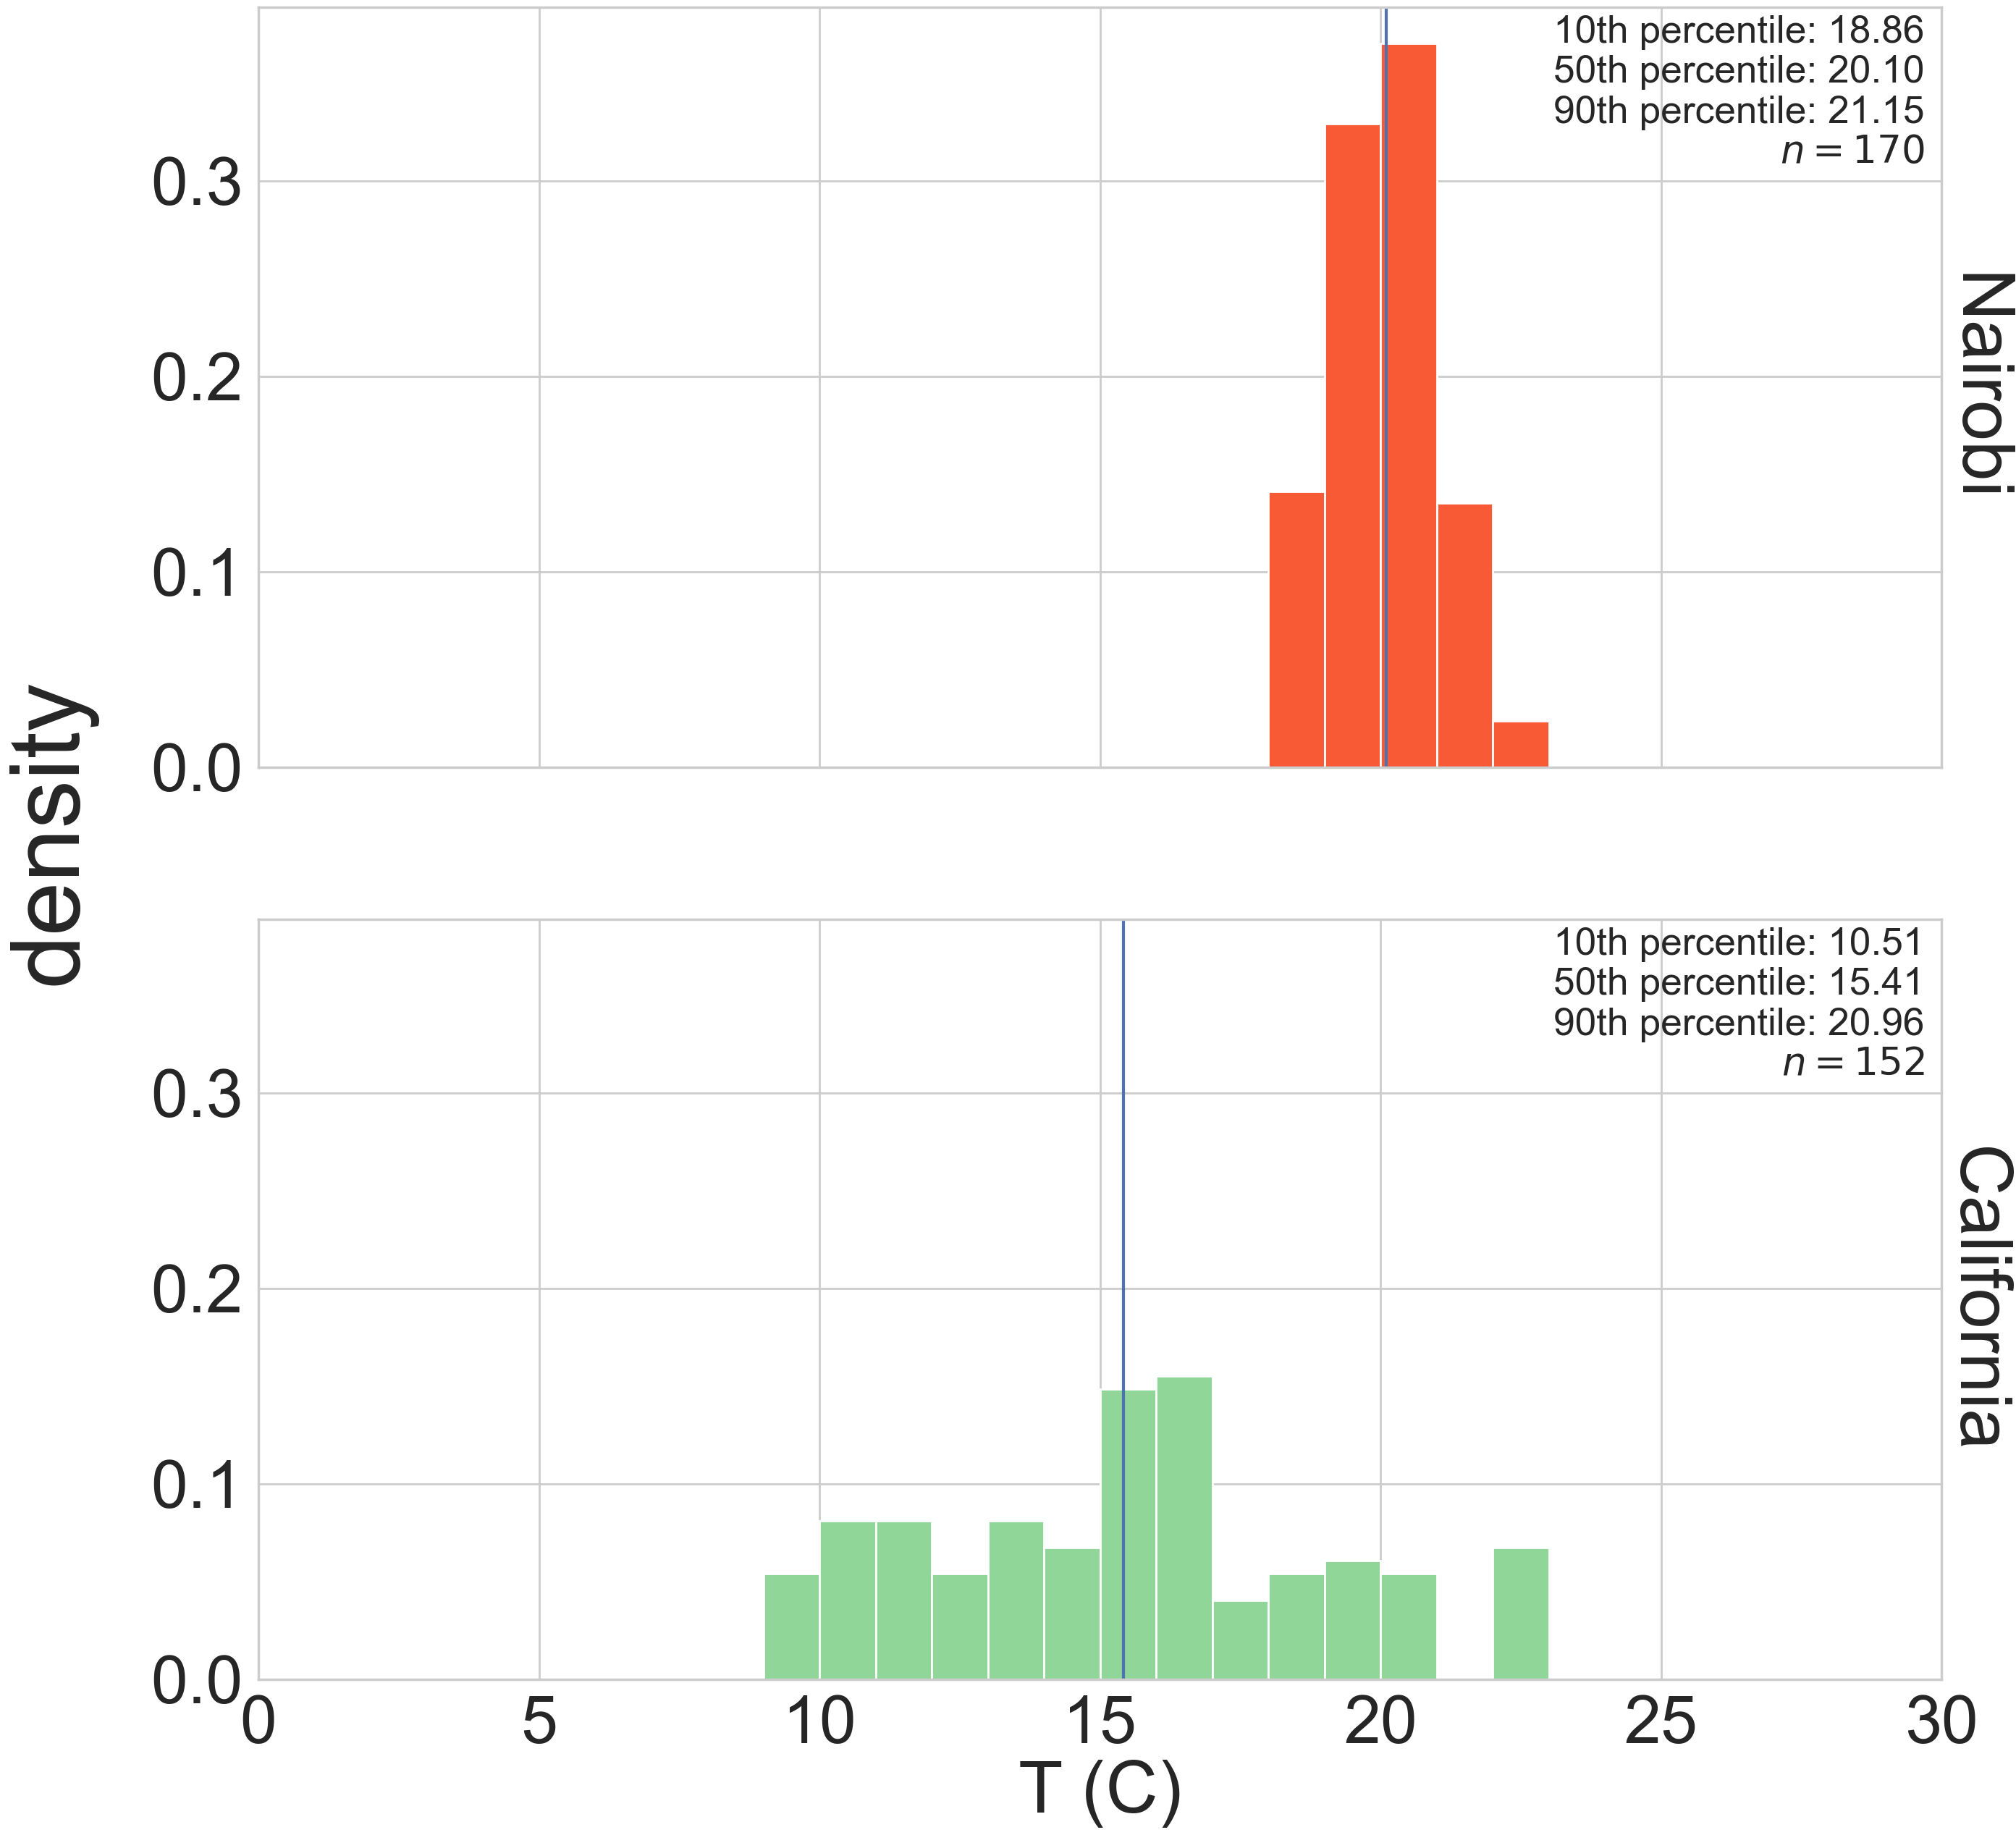

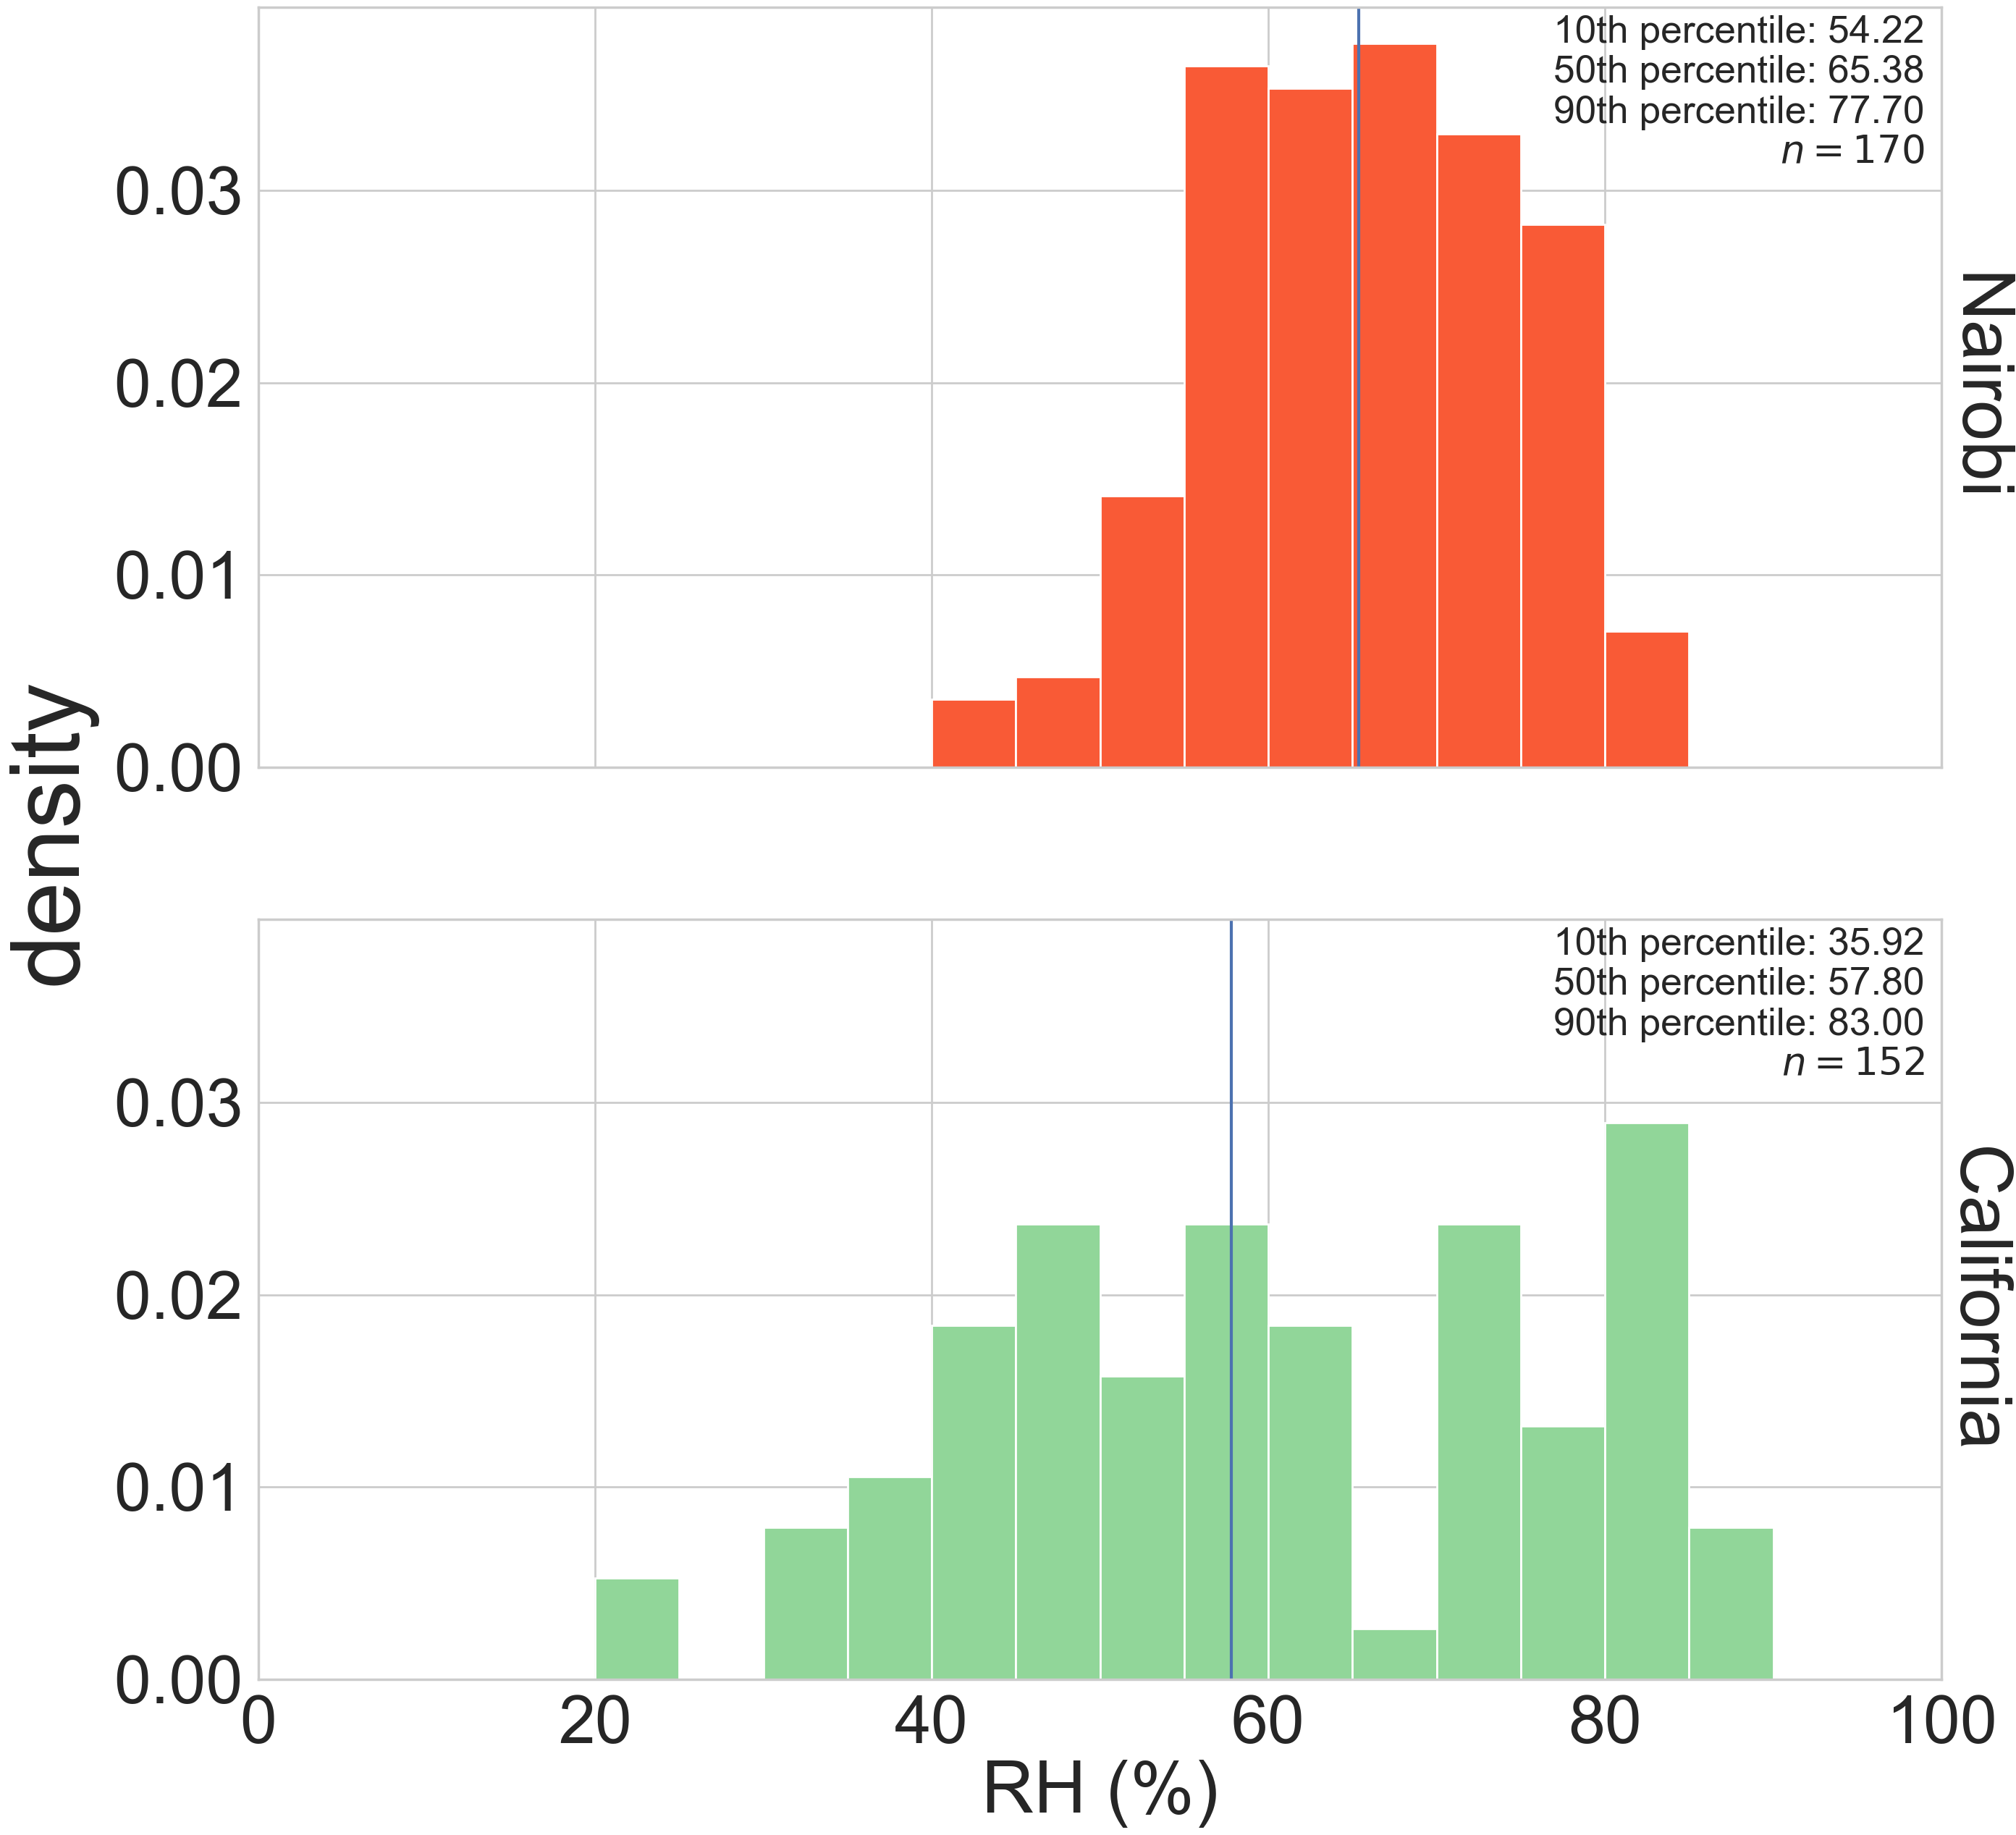

In [43]:
(s.fig_dir / "appendix a").mkdir(exist_ok=True)

with sns.axes_style("whitegrid"):
    for m in ["t_out_dailymean", "rh_out_dailymean"]:

        fig, axs = plt.subplots(2, 1, figsize=(30, 30), sharex=True, sharey=True)
        for ix, loc in enumerate(s.sites):
            ax = axs[ix]
            this_df = outs[m].loc[idx[loc, :]]
            this_df.hist(
                ax=ax, color=colors[loc], bins=out_dict[m]["bins"], density=True
            )
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(loc, rotation=270)
            ax.yaxis.set_label_coords(1.04, 0.5)
            ax.set_xlim(out_dict[m]["range"])

            n = outs.loc[idx[loc, :], :].shape[0]

            p50 = this_df.median()
            p10 = this_df.quantile(0.1)
            p90 = this_df.quantile(0.9)

            ax.axvline(p50)
            ax.text(
                0.99,
                0.99,
                "10th percentile: {:.2f}\n50th percentile: {:.2f}".format(p10, p50)
                + "\n90th percentile: {:.2f}\n$n={}$".format(p90, n),
                ha="right",
                va="top",
                transform=ax.transAxes,
                fontsize=fs,
            )

        fig.text(
            0.03,
            0.5,
            "density",
            ha="center",
            va="center",
            rotation="vertical",
            fontsize=fs_lab / 2,
        )
        ax.set_xlabel(out_dict[m]["xlabel"])

        fig.savefig(s.fig_dir / "appendix a" / f"outdoor_hist_{m.split('_')[0]}.png")

### Temperature Watercolors

Nairobi Control mean = 21.7
Nairobi control SD: 0.13786588258717364
N=79
Nairobi Treatment mean = 31.3
Nairobi treatment SD: 0.3269884427267688
N=77
California Control mean = 21.8
California control SD: 0.16802428344989076
N=76
California Treatment mean = 30.2
California treatment SD: 0.17976669889820587
N=76


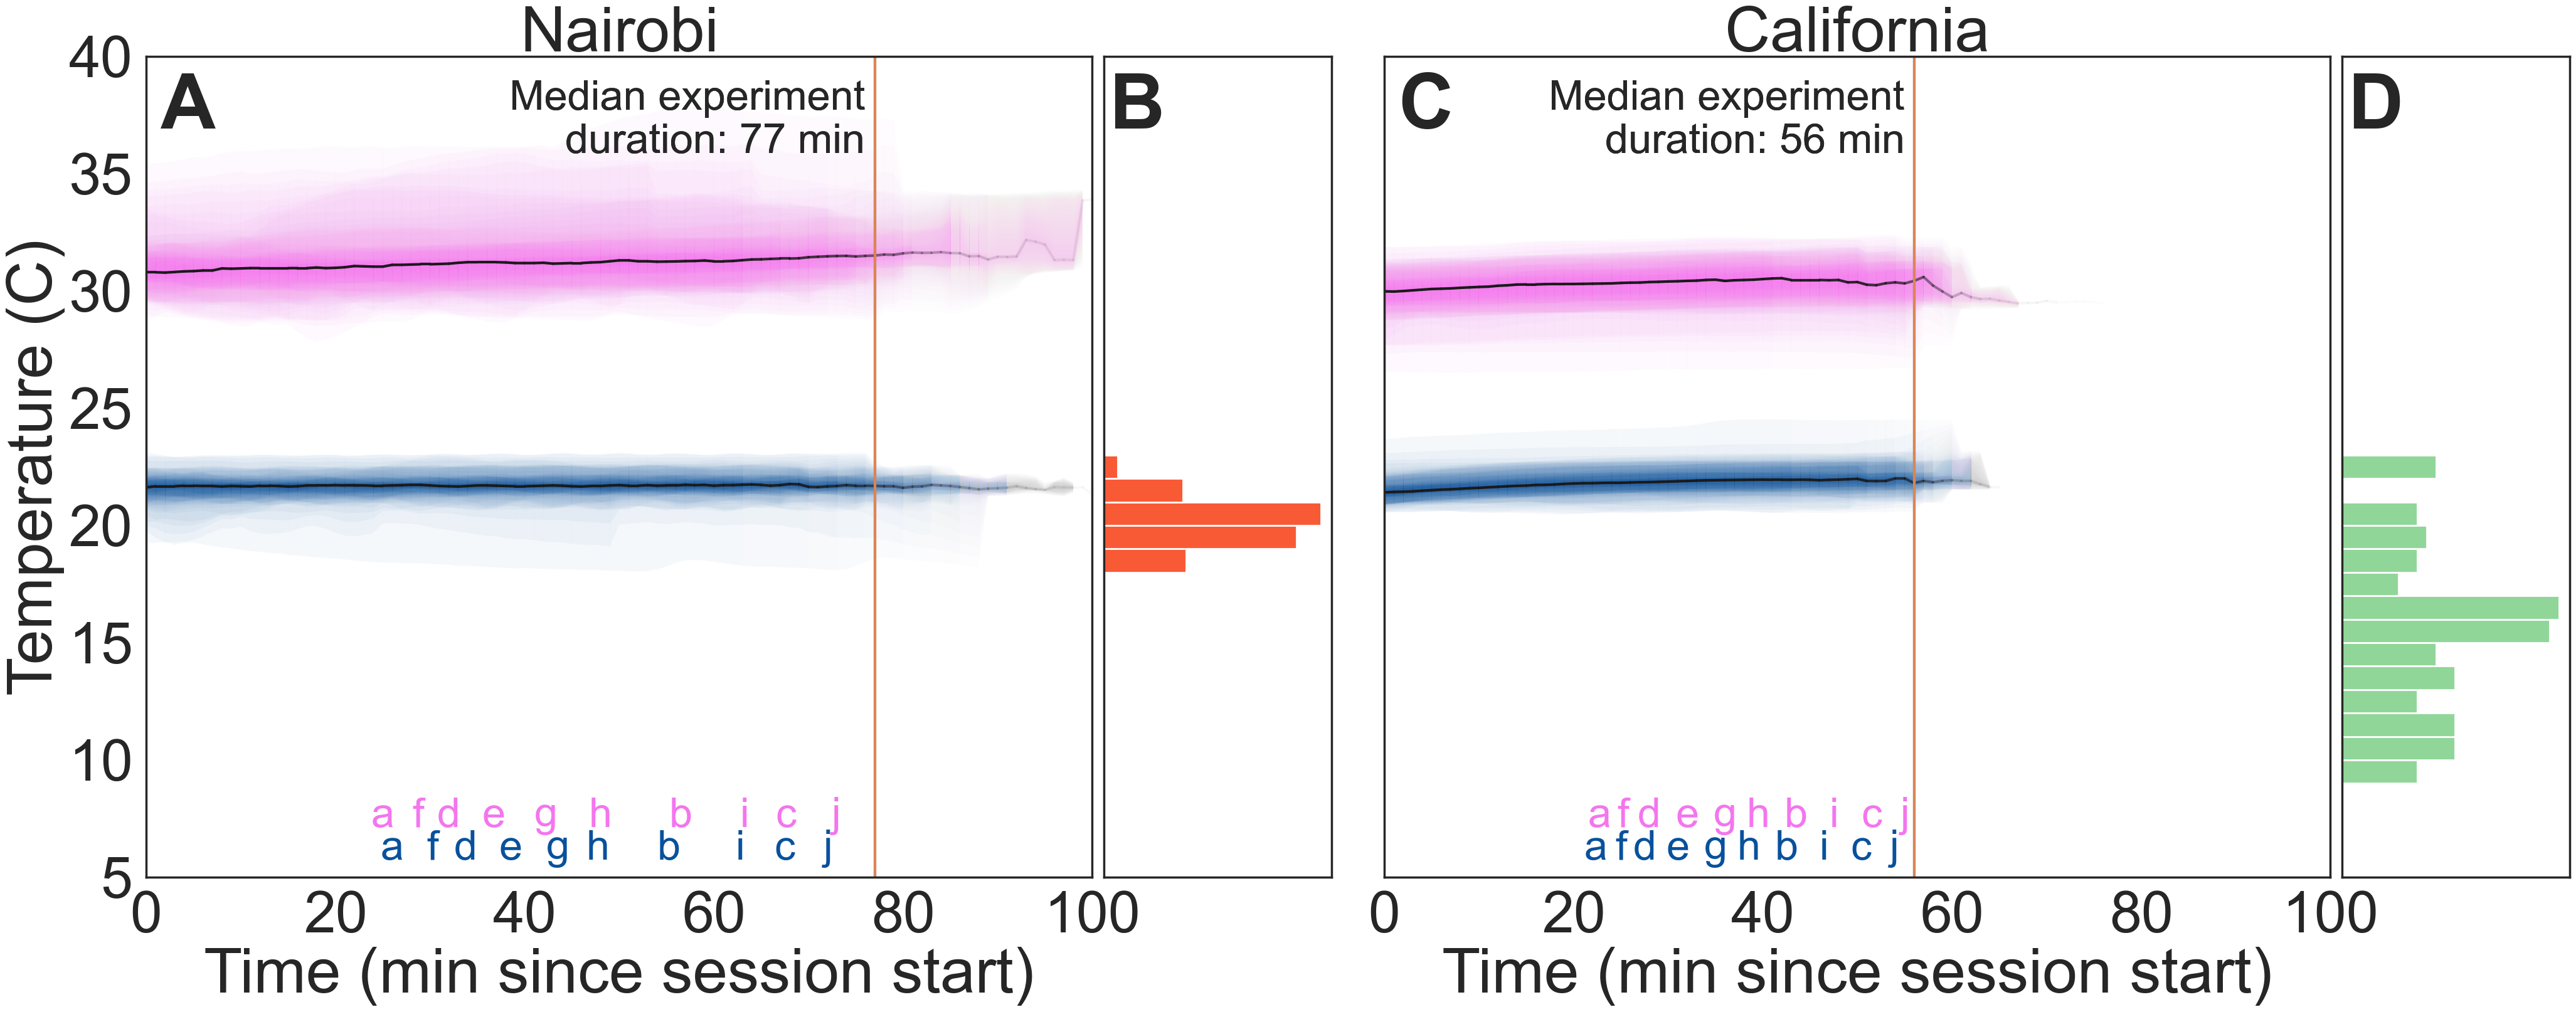

In [7]:
nullfmt = NullFormatter()


with sns.axes_style(style):
    fig = plt.figure(figsize=(42, 17))
    axs = []
    gs1 = gridspec.GridSpec(1, 5)
    gs1.update(left=0.06, right=0.51, wspace=0.05)
    axs.append(plt.subplot(gs1[:, :-1]))
    axs.append(plt.subplot(gs1[:, -1]))

    gs2 = gridspec.GridSpec(1, 5)
    gs2.update(left=0.53, right=0.98, wspace=0.05)
    axs.append(plt.subplot(gs2[:, :-1]))
    axs.append(plt.subplot(gs2[:, -1]))

    axs[0].set_ylabel("Temperature (C)")
    for six, site in enumerate(s.sites):
        lines = []
        ax = axs[six * 2]
        ax.set_title(site)
        ax_hist = axs[six * 2 + 1]

        outs["t_out_dailymean"].loc[idx[site, :]].hist(
            orientation="horizontal",
            bins=out_dict["t_out_dailymean"]["bins"],
            color=colors[site],
            ax=ax_hist,
        )
        ax_hist.grid(False)
        ax_hist.set_ylim((5, 40))
        ax_hist.yaxis.set_major_formatter(nullfmt)
        ax_hist.xaxis.set_major_formatter(nullfmt)

        for grpix, grp in enumerate(s.txs):
            if grp == "treatment":
                lab_ht = 29.9
            else:
                lab_ht = 20.7
            this_df = ts_dfs[site][grp]["room_avg_T"].copy()
            length = this_df.apply(lambda x: x.last_valid_index())
            this_df = this_df.apply(interpolate_within)

            sd = this_df.std()
            mean_of_sd = sd.mean()
            mean_of_mean = this_df.mean().mean()
            med = this_df.quantile(q=0.5, axis=1)
            count = this_df.count(axis=1)
            mean_of_med = (med * count).sum() / count.sum()
            med_length = length.median()
            n = this_df.shape[1]

            txt = "{} mean = {:.1f}".format(grp.title(), mean_of_mean)
            print(
                "{} {}\n{} {} SD: {}\nN={}".format(site, txt, site, grp, mean_of_sd, n)
            )

            for j in range(count.index.shape[0] - 1):
                (line,) = ax.plot(
                    med.index[j : j + 2],
                    med[j : j + 2],
                    color="k",
                    label=txt,
                    alpha=count[j] / count.max(),
                )
                if j == count.index.shape[0] - 2:
                    lines.append(line)
            ax.plot([med_length, med_length], [0, 40])
            ax.text(
                med_length - 1,
                39,
                "Median experiment\nduration: {:d} min".format(int(med_length)),
                verticalalignment="top",
                horizontalalignment="right",
                fontsize=fs,
            )
            for i in np.arange(0, 0.5, 0.01):
                this_quantile_low = this_df.quantile(q=i, axis=1)
                this_quantile_high = this_df.quantile(q=1 - i, axis=1)
                for j in range(count.index.shape[0] - 1):
                    poly = ax.fill_between(
                        [this_quantile_low.index[j], this_quantile_low.index[j + 1]],
                        this_quantile_low.iloc[j : j + 2],
                        this_quantile_high.iloc[j : j + 2],
                        alpha=0.0005 * count.iloc[j],
                        color=colors[grp],
                    )
                    poly.set_edgecolor("none")

            # add in time of module labels
            this_df_mod = t_mod_df.loc[idx[site, grp, :], :]
            for m in module_labs.keys():
                time = (
                    this_df_mod.loc[idx[site, grp, m], "end_time"]
                    + this_df_mod.loc[idx[site, grp, m], "st_time"]
                ) / 2
                ax.text(
                    time,
                    mod_time_ht[grp],
                    module_labs[m],
                    ha="center",
                    va="bottom",
                    color=colors[grp],
                    fontsize=fs,
                )

        ax.text(
            0.015,
            0.98,
            plot_labs[six * 2],
            va="top",
            transform=ax.transAxes,
            fontweight="bold",
            fontsize=fs_lab / 2,
        )
        ax_hist.text(
            0.025,
            0.98,
            plot_labs[six * 2 + 1],
            va="top",
            transform=ax_hist.transAxes,
            fontweight="bold",
            fontsize=fs_lab / 2,
        )
        ax.set_xlabel("Time (min since session start)")
        ax.set_ylim((5, 40))

    axs[0].set_xlim((0, 100))
    axs[2].set_xlim((0, 100))
    axs[2].yaxis.set_major_formatter(nullfmt)

fig.savefig(s.fig_dir / "figure 1" / f"watercolor_temps_{style}_squished.pdf")

### Boxplots

#### T_op

In [8]:
Top_box_df = []
for site in s.sites:
    dfs = {"T_op": {}, "T": {}}
    timing = timing_dfs[site].loc[:, ["Date", "Session in day", "Treatment group"]]
    for i, tx in enumerate(s.txs):
        dfs["T_op"][tx] = ts_dfs[site][tx]["T_op"].T
        dfs["T"][tx] = ts_dfs[site][tx]["room_avg_T"].T
        dfs["T"][tx] = dfs["T"][tx].reindex(dfs["T_op"][tx].index)

        # take only 5 minute measurements to match T_op
        dfs["T_op"][tx].columns = dfs["T_op"][tx].columns * 5
        dfs["T"][tx] = dfs["T"][tx].loc[:, dfs["T_op"][tx].columns]
        dfs["T"][tx] = dfs["T"][tx].loc[:, ~dfs["T"][tx].isnull().all(axis=0)]

        # make sure we get same measurements from each session-condition
        # for both T and T_op
        dfs["T"][tx] = dfs["T"][tx].where(
            (dfs["T"][tx].notnull()) & (dfs["T_op"][tx].notnull()), np.nan
        )
        dfs["T_op"][tx] = dfs["T_op"][tx].where(
            (dfs["T"][tx].notnull()) & (dfs["T_op"][tx].notnull()), np.nan
        )

        dfs["T"][tx] = dfs["T"][tx].join(timing.loc[timing["Treatment group"] == i])
        del dfs["T"][tx]["Treatment group"]
        dfs["T"][tx].set_index(["Date", "Session in day"], drop=True, inplace=True)
        dfs["T_op"][tx] = dfs["T_op"][tx].join(
            timing.loc[timing["Treatment group"] == i]
        )
        del dfs["T_op"][tx]["Treatment group"]
        dfs["T_op"][tx].set_index(["Date", "Session in day"], drop=True, inplace=True)

    dfs["T_op"]["diff"] = dfs["T_op"]["treatment"] - dfs["T_op"]["control"]
    dfs["T_op"]["diff"].dropna(how="all", inplace=True)
    dfs["T"]["diff"] = dfs["T"]["treatment"] - dfs["T"]["control"]
    dfs["T"]["diff"].dropna(how="all", inplace=True)

    for t_type in ["T", "T_op"]:
        for tx in ["control", "treatment", "diff"]:
            dfs[t_type][tx] = pd.DataFrame({"T": np.array(dfs[t_type][tx]).flatten()})
            dfs[t_type][tx] = dfs[t_type][tx][dfs[t_type][tx].notnull()["T"]]
            dfs[t_type][tx]["Group"] = tx
            dfs[t_type][tx]["Site"] = site
            dfs[t_type][tx]["T_type"] = t_type
            dfs[t_type][tx].reset_index(drop=True, inplace=True)
            Top_box_df.append(dfs[t_type][tx])

Top_box_df = (
    pd.concat(Top_box_df)
    .reset_index(drop=True)
    .rename(columns={"T": "Temp (C)", "T_type": "Measurement"})
)
Top_box_df["Group"] = Top_box_df["Group"].str.title()


def label_func(x):
    if x == "Control":
        return "A) Control"
    elif x == "Treatment":
        return "B) Treatment"
    elif x == "Diff":
        return "C) Diff"


Top_box_df["Group"] = Top_box_df["Group"].apply(label_func)

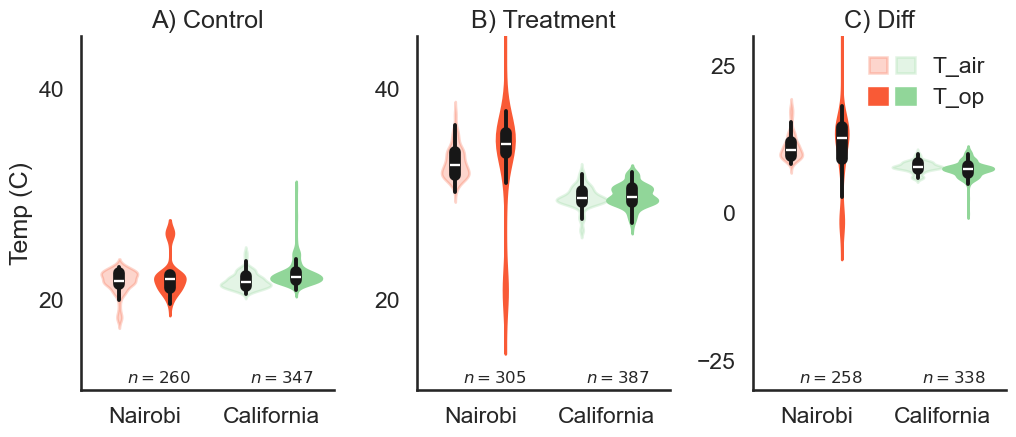

In [9]:
kind = "violin"
tup_handl = HandlerTuple(ndivide=None)
ns = Top_box_df.groupby(["Group", "Site", "Measurement"]).count()
panels = ["A) Control", "B) Treatment", "C) Diff"]
with sns.plotting_context("talk", rc={"lines.linewidth": 1}):
    with sns.axes_style(style):
        g = sns.catplot(
            x="Site",
            y="Temp (C)",
            hue="Measurement",
            col="Group",
            data=Top_box_df,
            kind=kind,
            height=5,
            aspect=0.7,
            sharey=False,
            hue_order=["T", "T_op"],
            palette="dark:grey",
            legend=False,
        )
        g.set_axis_labels("", "Temp (C)").set_titles("{col_name}")

        ax = g.axes
        lb = min(ax[0, 0].get_ylim()[0], ax[0, 1].get_ylim()[0])
        ub = 45
        ax[0, 0].set_ylim((lb, ub))
        ax[0, 1].set_ylim((lb, ub))
        ax[0, 2].set_ylim((-30, 30))
        for aix, a in enumerate(ax.flatten()):
            [a.collections[i].set_color(colors["Nairobi"]) for i in [0, 1]]
            [a.collections[i].set_color(colors["California"]) for i in [2, 3]]
            [a.collections[i].set_alpha(0.25) for i in [0, 2]]
            n_N = ns.loc[idx[panels[aix], "Nairobi", "T"], "Temp (C)"]
            n_C = ns.loc[idx[panels[aix], "California", "T"], "Temp (C)"]
            a.text(
                0.18,
                0.02,
                f"$n={n_N}$             $n={n_C}$",
                transform=a.transAxes,
                fontsize=fs / 4,
            )

        handles = [
            (a.collections[0], a.collections[2]),
            (a.collections[1], a.collections[3]),
        ]
        lab = ["T_air", "T_op"]
        a.legend(
            handles,
            lab,
            handler_map={tuple: tup_handl},
            loc="upper right",
            edgecolor="none",
        )
plt.savefig(s.fig_dir / "appendix h" / f"{kind}_Top.png")

### RH

In [10]:
box_dfs = {}
RH_box_df = []
for site in s.sites:
    timing = timing_dfs[site].loc[:, ["Date", "Session in day", "Treatment group"]]
    for i, tx in enumerate(s.txs):
        box_dfs[tx] = ts_dfs[site][tx]["room_avg_RH"].T

        box_dfs[tx] = box_dfs[tx].join(timing.loc[timing["Treatment group"] == i])
        del box_dfs[tx]["Treatment group"]
        box_dfs[tx].set_index(["Date", "Session in day"], drop=True, inplace=True)

    box_dfs["diff"] = box_dfs["treatment"] - box_dfs["control"]
    box_dfs["diff"].dropna(how="all", inplace=True)

    for tx in ["control", "treatment", "diff"]:
        box_dfs[tx] = pd.DataFrame({"RH": np.array(box_dfs[tx]).flatten()})
        box_dfs[tx] = box_dfs[tx][box_dfs[tx].notnull()["RH"]]
        box_dfs[tx]["Group"] = tx
        box_dfs[tx]["Site"] = site
        box_dfs[tx].reset_index(drop=True, inplace=True)
        RH_box_df.append(box_dfs[tx])

RH_box_df = (
    pd.concat(RH_box_df)
    .reset_index(drop=True)
    .rename(columns={"RH": "Relative Humidity (%)"})
)
RH_box_df["Group"] = RH_box_df["Group"].str.title()


def label_func(x):
    if x == "Control":
        return "A) Control"
    elif x == "Treatment":
        return "B) Treatment"
    elif x == "Diff":
        return "C) Diff"


RH_box_df["Group"] = RH_box_df["Group"].apply(label_func)

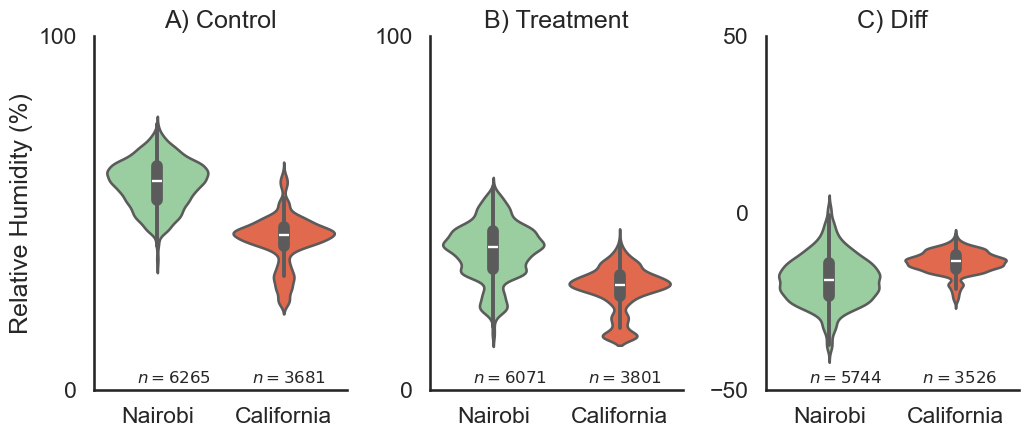

In [11]:
kind = "violin"
ns_RH = RH_box_df.groupby(["Group", "Site"]).count()
with sns.plotting_context("talk", rc={"lines.linewidth": 1}):
    with sns.axes_style(style):
        g = sns.catplot(
            x="Site",
            y="Relative Humidity (%)",
            col="Group",
            data=RH_box_df,
            kind=kind,
            height=5,
            aspect=0.7,
            sharey=False,
            hue="Site",
            palette=[colors["California"], colors["Nairobi"]],
            legend=False,
        )
        ax = g.axes
        lb = 0
        ub = 100
        ax[0, 0].set_ylim((lb, ub))
        ax[0, 1].set_ylim((lb, ub))
        ax[0, 2].set_ylim((-50, 50))
        for aix, a in enumerate(ax.flatten()):
            n_N = ns_RH.loc[idx[panels[aix], "Nairobi"], "Relative Humidity (%)"]
            n_C = ns_RH.loc[idx[panels[aix], "California"], "Relative Humidity (%)"]
            a.text(
                0.17,
                0.02,
                "$n={}$         $n={}$".format(n_N, n_C),
                transform=a.transAxes,
                fontsize=fs / 4,
            )

        g.set_axis_labels("", "Relative Humidity (%)").set_titles("{col_name}")
plt.savefig(s.fig_dir / "appendix h" / f"{kind}_RH.png")

### CO2

In [12]:
box_dfs = {}
CO2_box_df = []
for site in s.sites:
    timing = timing_dfs[site].loc[:, ["Date", "Session in day", "Treatment group"]]
    for i, tx in enumerate(s.txs):
        box_dfs[tx] = ts_dfs[site][tx]["CO2"].T
        box_dfs[tx] = box_dfs[tx].join(timing.loc[timing["Treatment group"] == i])
        del box_dfs[tx]["Treatment group"]
        box_dfs[tx].set_index(["Date", "Session in day"], drop=True, inplace=True)

    box_dfs["diff"] = box_dfs["treatment"] - box_dfs["control"]
    box_dfs["diff"].dropna(how="all", inplace=True)

    for tx in ["control", "treatment", "diff"]:
        box_dfs[tx] = pd.DataFrame({"CO2": np.array(box_dfs[tx]).flatten()})
        box_dfs[tx] = box_dfs[tx][box_dfs[tx].notnull()["CO2"]]
        box_dfs[tx]["Group"] = tx
        box_dfs[tx]["Site"] = site
        box_dfs[tx].reset_index(drop=True, inplace=True)
        CO2_box_df.append(box_dfs[tx])

CO2_box_df = (
    pd.concat(CO2_box_df).reset_index(drop=True).rename(columns={"CO2": "CO2 (ppm)"})
)
CO2_box_df["Group"] = CO2_box_df["Group"].str.title()


def label_func(x):
    if x == "Control":
        return "A) Control"
    elif x == "Treatment":
        return "B) Treatment"
    elif x == "Diff":
        return "C) Diff"


CO2_box_df["Group"] = CO2_box_df["Group"].apply(label_func)

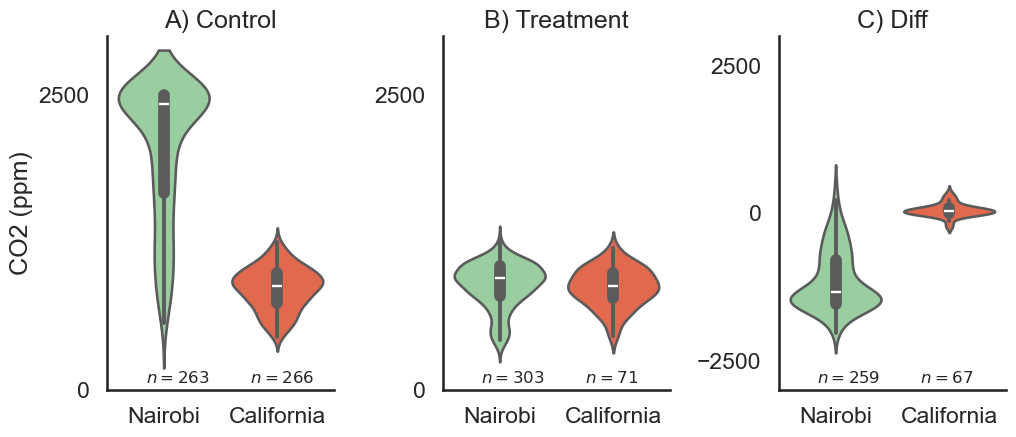

In [13]:
kind = "violin"
ns_CO2 = CO2_box_df.groupby(["Group", "Site"]).count()
with sns.plotting_context("talk", rc={"lines.linewidth": 1}):
    with sns.axes_style(style):
        g = sns.catplot(
            x="Site",
            y="CO2 (ppm)",
            col="Group",
            data=CO2_box_df,
            kind=kind,
            height=5,
            aspect=0.7,
            sharey=False,
            hue="Site",
            palette=[colors["California"], colors["Nairobi"]],
            legend=False,
        )
        ax = g.axes
        lb = 0
        ub = 3000
        ax[0, 0].set_ylim((lb, ub))
        ax[0, 1].set_ylim((lb, ub))
        ax[0, 2].set_ylim((-3000, 3000))
        for aix, a in enumerate(ax.flatten()):
            n_N = ns_CO2.loc[idx[panels[aix], "Nairobi"], "CO2 (ppm)"]
            n_C = ns_CO2.loc[idx[panels[aix], "California"], "CO2 (ppm)"]
            a.text(
                0.17,
                0.02,
                "$n={}$         $n={}$".format(n_N, n_C),
                transform=a.transAxes,
                fontsize=fs / 4,
            )

        g.set_axis_labels("", "CO2 (ppm)").set_titles("{col_name}")
plt.savefig(s.fig_dir / "appendix h" / f"{kind}_CO2.png")

## Summary table of other environmental vars

In [14]:
fpaths = {
    "California": s.berk.env_out_path,
    "Nairobi": s.bus.env_out_path,
}


def p_to_stars(pval):
    if pval < 0.01:
        return "**"
    elif pval < 0.05:
        return "*"
    else:
        return ""

In [15]:
sess_dfs = {}
for f in fpaths.keys():
    sess_dfs[f] = pd.read_csv(
        fpaths[f],
        usecols=[
            "RH_in_mean",
            "Top_mean",
            "co2_mean",
            "T_in_mean",
            "date",
            "session",
            "treatment",
        ],
        index_col=["date", "session", "treatment"],
    )

In [16]:
measured_vars = ["T_op", "CO2", "lighting", "background_noise"]

results = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        (measured_vars, ["mean", "std"]), names=["Variable", "Metric"]
    ),
    columns=pd.MultiIndex.from_product(([s.sites, ["Control", "Heat", "n", "diff"]])),
    dtype=np.float64,
).astype({("Nairobi", "diff"): str, ("California", "diff"): str})
results.loc[:, idx[:, "diff"]] = ""


for loc in s.sites:
    this_df = (
        sess_dfs[loc]
        .loc[:, ["Top_mean", "co2_mean"]]
        .rename(columns={"Top_mean": "T_op", "co2_mean": "CO2"})
        .rename(index={0: "Control", 1: "Heat"}, level=2)
    )

    # take only sessions where measurements for both control and hot
    valid = this_df.groupby(level=[0, 1]).count() == 2
    new_df = this_df.join(valid, on=["date", "session"], rsuffix="_valid")
    for i in ["T_op", "CO2"]:
        new_df[i] = new_df[i].where(new_df[i + "_valid"], np.nan)
    this_df = new_df[["T_op", "CO2"]]

    # get sample size
    ns = this_df.groupby(level=2).count().T["Control"]
    for i in ["T_op", "CO2"]:
        results.loc[idx[i, "mean"], idx[loc, "n"]] = ns[i]

    for metric in ["mean", "std"]:
        vals = this_df.groupby(level=2).agg(metric).T
        vals.index = pd.MultiIndex.from_product([vals.index, [metric]])
        vals.columns = pd.MultiIndex.from_product([[loc], ["Control", "Heat"]])
        vals.index.names = ["Variable", "Metric"]
        results.loc[vals.index, vals.columns] = vals

    # get p-val
    for var in ["T_op", "CO2"]:
        ctrl = this_df.loc[idx[:, :, "Control"], var].reset_index(level=2, drop=True)
        tx = this_df.loc[idx[:, :, "Heat"], var].reset_index(level=2, drop=True)

        # correct for when measured in one room not other
        diff = ctrl.index.intersection(tx.index)
        ctrl = ctrl.reindex(diff)
        tx = tx.reindex(diff)

        pval = ttest_rel(ctrl, tx, nan_policy="omit").pvalue
        results.loc[idx[var, "mean"], idx[loc, "diff"]] = p_to_stars(pval)

results.loc[idx[:, "std"], idx[:, "diff"]] = ""

#### incorporate measured-once metrics

##### Berkeley

In [17]:
# lighting

lighting_df = pd.read_csv(
    s.berk.other_dir / "lighting_lux.csv",
    index_col=0,
    nrows=6,
    usecols=["Participant No.", "Control Avg", "Treatment Avg"],
)
lighting_df.rename(
    columns={"Control Avg": "Control", "Treatment Avg": "Heat"}, inplace=True
)

vals = {}
for m in ["mean", "std"]:
    vals = lighting_df.agg(m)
    vals.index = pd.MultiIndex.from_product([["California"], vals.index])

    results.loc[idx["lighting", m], idx["California", ["Control", "Heat"]]] = vals

pval = ttest_ind(lighting_df["Control"], lighting_df["Heat"]).pvalue
results.loc[idx["lighting", "mean"], idx["California", "diff"]] = p_to_stars(pval)

# noise
noise_df = pd.read_csv(s.berk.other_dir / "sound_dba.csv")
results.loc[idx["background_noise", "mean"], idx["California", "Control"]] = (
    noise_df.loc[0, "control"]
)
results.loc[idx["background_noise", "mean"], idx["California", "Heat"]] = noise_df.loc[
    0, "treatment"
]

##### Nairobi

In [18]:
enviro_df = pd.read_csv(
    s.bus.other_dir / "Light & Sound Data.csv",
    index_col=0,
    nrows=6,
    header=1,
    usecols=["Participant No.", "Control Avg", "Treatment Avg", "Av", "AV"],
)

enviro_df.columns = pd.MultiIndex.from_product(
    [["Nairobi"], ["lighting", "background_noise"], ["Control", "Heat"]]
)

for m in ["mean", "std"]:
    vals = enviro_df.agg(m)
    vals = vals.unstack(level=[0, 2])
    vals.index = pd.MultiIndex.from_product(
        [vals.index, [m]], names=["Variable", "Metric"]
    )

    results.loc[
        idx[["background_noise", "lighting"], m], idx["Nairobi", ["Control", "Heat"]]
    ] = vals

for m in ["lighting", "background_noise"]:
    pval = ttest_ind(
        enviro_df[idx["Nairobi", m, "Control"]], enviro_df[idx["Nairobi", m, "Heat"]]
    ).pvalue
    results.loc[idx[m, "mean"], idx["Nairobi", "diff"]] = p_to_stars(pval)

##### Formatting

In [19]:
idx_relabel = {
    "T_op": "T_op (C)",
    "CO2": "CO2 (ppm)",
    "lighting": "Lighting (lux)",
    "background_noise": "Background Noise (dBa)",
}


def sd_func(x):
    if np.isnan(x):
        return ""
    else:
        return "({:.1f})".format(x)

In [20]:
idx_relabel = {
    "T_op": "T_op (C)",
    "CO2": "CO2 (ppm)",
    "lighting": "Lighting (lux)",
    "background_noise": "Background Noise (dBa)",
}


def sd_func(x):
    if np.isnan(x):
        return ""
    else:
        return "({:.1f})".format(x)


results = results.astype({k: str if k[1] == "n" else object for k in results.columns})
results.loc[idx[:, "std"], idx[:, ["Control", "Heat"]]] = results.loc[
    idx[:, "std"], idx[:, ["Control", "Heat"]]
].map(sd_func)
results.loc[idx[:, "mean"], idx[:, ["Control", "Heat"]]] = results.loc[
    idx[:, "mean"], idx[:, ["Control", "Heat"]]
].map("{:.1f}".format)


def diff_func(x):
    if x == "nan":
        return "N/A"
    else:
        return x


results.loc[:, idx[:, "diff"]] = results.loc[:, idx[:, "diff"]].map(diff_func)

results.index = results.index.droplevel(1)

this_idx = list(results.index)
for i in range(len(this_idx)):
    if i % 2:
        this_idx[i] = ""

results.index = pd.Index(this_idx, name="Variable")
results.rename(index=idx_relabel, inplace=True)

# fix sample size col
results.loc[(results.loc[:, idx[:, "n"]] == "nan").all(axis=1), idx[:, "n"]] = ""
results.loc[:, idx[:, "n"]] = results.loc[:, idx[:, "n"]].map(lambda f: f.split(".")[0])

In [21]:
results

Nairobi                   California                  
                        Control     Heat   n diff    Control     Heat   n diff
Variable                                                                      
T_op (C)                   22.1     33.3  18   **       22.4     29.9  30   **
                          (1.6)    (4.8)               (0.8)    (1.1)         
CO2 (ppm)                2036.8    903.3  18   **      817.6    867.3   6     
                        (330.1)  (134.7)              (87.0)   (90.2)         
Lighting (lux)             76.7     80.4               466.8    410.8         
                         (13.4)   (18.7)             (171.3)  (224.9)         
Background Noise (dBa)     48.4     55.5       **       44.0     47.0         
                          (3.5)    (1.7)

In [22]:
table_dir = s.table_dir / "appendix h"
table_dir.mkdir(exist_ok=True, parents=True)
results.to_latex(
    table_dir / "environmental_metrics.tex",
    column_format="rcccccccc",
    longtable=False,
    multicolumn_format="c",
)